### 1. Preliminaries

In [14]:
import utils as ut

import os
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [15]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE
drop_no_regime = False # set to true if  you want to drop events that occur under 'No-regime' weather regime

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/temporal_composite/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/temporal_composite/'

In [16]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data_stacked = ut.load_data(ENERGY_PATH, VARIABLE)
data_rank = data_stacked.compute().rank(dim='event', pct=True)

if VARIABLE == 'total_RE':
    data_rank = 1 - data_rank

In [17]:
PATH_ED = '../../energydroughts-Europe/data/'
# ped = pd.read_csv(os.path.join(PATH_ED, 'PED_residual_q0.97_winter_LENTIS_PD_02_v4.csv')).reset_index(drop=True)
ed = pd.read_csv(os.path.join(PATH_ED, 'residual_el7_winter_LENTIS_PD_02_v4_1600_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)
df_events['start_time'] = pd.to_datetime(df_events['start_time'])
df_events['end_time'] = pd.to_datetime(df_events['end_time'])

In [18]:
df_raw = ut.merge_cluster_data(cluster_path = "../Results/clusters_v4/clusters_all.csv", data_rank = data_rank)

if drop_no_regime:
    df = df_raw[df_raw['cluster_id'] != 4] # remove cluster 4, which is no-regime
    print(f'Fraction of data that was no-regime: {(len(df_raw) - len(df) ) / len(df_raw):.2f} is removed')
else:
    df = df_raw.copy()

In [57]:
too_early_events = df_events.query('start_time < "2000-02-08"') # otherwise no energy data available 7 days before event
too_late_events = df_events.query('end_time > "2009-11-23"') # otherwise no energy data available 7 days after event
df_events.drop(too_early_events.index, inplace=True)
df_events.drop(too_late_events.index, inplace=True)

### 2. Define functions

In [22]:
# include no-regime days (cluster 4) or not?
#FIXME: Leap-days get a 'NaN' cluster.

def get_events_df_multipleday(df_event):
    df_event['composite_start'] = df_event['start_time'] - pd.Timedelta(days=7)
    df_event['composite_end'] = df_event['end_time'] + pd.Timedelta(days=7)
    return df_event

In [23]:
def check_overlap(run_times, run, event_time):
    if run in run_times and any(start <= event_time <= end for start, end in run_times[run]):
        return True
    return False

def update_run_times(run_times, run, start_time, end_time):
    if run not in run_times:
        run_times[run] = []
    run_times[run].append((start_time, end_time))
    return run_times

def get_event_timeseries(df_raw, country_name, start_time, end_time, run):
    return df_raw[(df_raw['country_name'] == country_name) & 
                  (df_raw['time'] >= start_time) & 
                  (df_raw['time'] <= end_time) & 
                  (df_raw['run'] == run)]

def plot_data_shading(t, all_series, mean_series, median_series, dominant_cluster, country_name, num_events):

    # Calculate percentiles
    p0, p25, p40, p60, p75, p100 = np.percentile(all_series, [0, 25, 40, 60, 75, 100], axis=0)

    # Plot percentiles as shaded areas
    plt.fill_between(t, p0, p100, color='red', alpha=0.1, label='0-100 percentile')
    plt.fill_between(t, p25, p75, color='red', alpha=0.25, label='25-75 percentile')
    plt.fill_between(t, p40, p60, color='red', alpha=0.4, label='40-60 percentile')

    # Plot mean and median
    plt.plot(t, mean_series, 'r', alpha = 1, label = 'Mean')
    plt.plot(t, median_series, 'b', alpha = 1, label = 'Median')

    # for i in range(4):
    #     cluster = np.where(np.asarray(dominant_cluster) == i)
    #     mean_cluster = all_series[cluster, :].squeeze().mean(axis = 0)
    #     if len(cluster[0]) > 1:
    #         plt.plot(t, mean_cluster, label = f'Cluster {i}')
    plt.axvline(0, color = 'k', linestyle = '--', alpha = 0.5)
    plt.axvline(6, color = 'k', linestyle = '--', alpha = 0.5)

    plt.xlabel('Days relative to event')
    plt.ylabel('Residual load (percentile)')
    # xticks for every day
    plt.xticks(np.arange(-7, WINDOW + 7, 1))
    
    plt.legend()
    plt.savefig(dir_Figures + f'{country_name}_{num_events}.png', dpi = 300)

def find_dominant_cluster(event_timeseries, dominant_cluster):
    cluster_counts = event_timeseries['cluster_id'][7:14].value_counts()
    if cluster_counts.iloc[0] > 6:
        dominant_cluster.append(int(cluster_counts.index[0]))
    # if difference between first and second cluster is larger than 2 days, then the first one is dominant (arbitrary choice)
    elif cluster_counts.iloc[0] - cluster_counts.iloc[1] > 2: 
        dominant_cluster.append(int(cluster_counts.index[0]))
    elif cluster_counts.iloc[0] - cluster_counts.iloc[1] < 2:
        dominant_cluster.append(5) # no dominant cluster

In [28]:
def temporal_composite(df, country_name, num_events, dt = 7, plot = True):
    t = np.arange(-dt, WINDOW + dt)
    df_country_event = df[df['country'] == country_name].reset_index(drop = True)

    all_series = np.zeros((num_events, len(t)))
    dominant_cluster = []

    progress_bar = tqdm(total=num_events)

    for i, row in df_country_event.iterrows():
        start_time = str(row['composite_start'])
        end_time = str(row['composite_end'])
        run = row['run']

        event_timeseries = get_event_timeseries(df_raw, country_name, start_time, end_time, run)
        all_series[i] = event_timeseries['residual'].values
        find_dominant_cluster(event_timeseries, dominant_cluster)
        progress_bar.update()
        
        if i == num_events - 1:
            break
        
    dominant_cluster = np.asarray(dominant_cluster)

    mean_series = all_series.mean(axis=0)
    median_series = np.median(all_series, axis = 0)

    if plot:
        plot_data_shading(t, all_series, mean_series, median_series, dominant_cluster, country_name, num_events)

    return all_series, mean_series, median_series, dominant_cluster

### 3. Perform analysis of temporal composites

In [26]:
df_event = get_events_df_multipleday(df_events)

  0%|          | 0/100 [00:00<?, ?it/s]

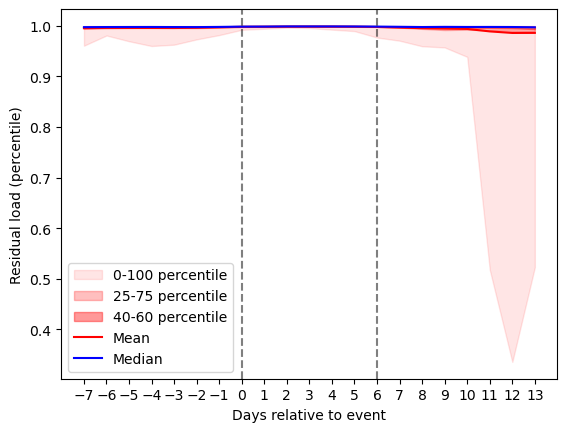

In [29]:
all_series, mean_series, median_series, dominant_cluster = temporal_composite(df_event, 'NOR', 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

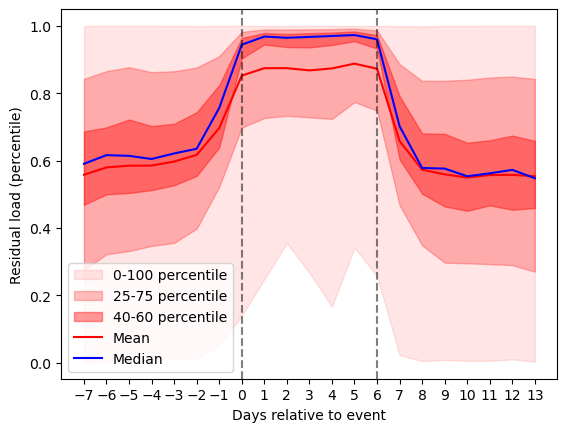

In [62]:
all_series, mean_series, median_series, dominant_cluster = temporal_composite(df_event, 'NLD', 1000)

(array([334.,  70.,  11., 207.,  16., 250.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

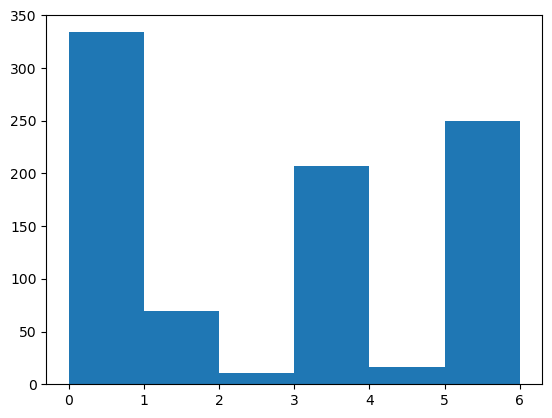

In [63]:
plt.hist(dominant_cluster, bins = np.arange(7))

  0%|          | 0/1000 [00:00<?, ?it/s]

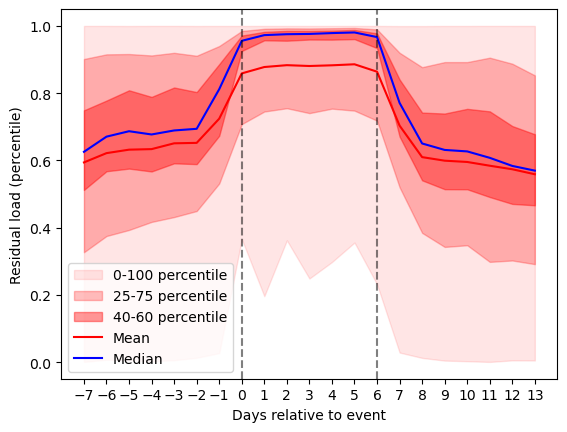

In [64]:
all_series, mean_series, median_series, dominant_cluster = temporal_composite(df_event, 'DEU', 1000)

(array([316.,  98.,   7., 203.,  17., 247.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

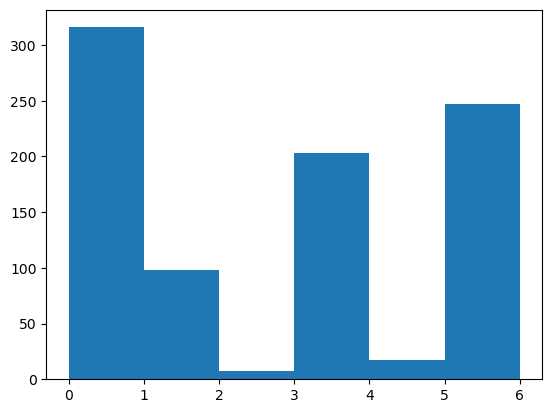

In [65]:
plt.hist(dominant_cluster, bins = np.arange(7))

### Code graveyard

In [ ]:
def temporal_composite_old(df, country_name, num_events, dt = 7, plot = True):
    """Use this one if you get errors with the new one, but I think it should not be required anymore"""
    t = np.arange(-dt, WINDOW + dt)
    df_country_event = df[df['country'] == country_name].reset_index(drop = True)

    all_series = np.zeros((num_events, len(t)))
    dominant_cluster = []

    run_times = {} # to check for no overlapping timeseries

    unique = 0
    incomplete = 0
    double = 0

    progress_bar = tqdm(total=num_events)

    for i, row in df_country_event.iterrows():
        start_time = str(row['composite_start'])
        end_time = str(row['composite_end'])
        run = row['run']
        event_time = str(pd.to_datetime(start_time) + pd.Timedelta(days=7))
        event_end = str(pd.to_datetime(event_time) + pd.Timedelta(days=6))

        if check_overlap(run_times, run, event_time):
            double += 1
            continue

        event_timeseries = get_event_timeseries(df_raw, country_name, start_time, end_time, run)
        
        #HACK: Find a solution for this
        if len(event_timeseries) == len(t):
            all_series[unique] = event_timeseries['residual'].values
            find_dominant_cluster(event_timeseries, dominant_cluster)
            unique += 1
            progress_bar.update()
            if run not in run_times:
                run_times[run] = []
            run_times[run].append((event_time, event_end))
        elif len(event_timeseries) < len(t):
            incomplete += 1

        if unique == num_events:
            break
        
    dominant_cluster = np.asarray(dominant_cluster)

    mean_series = all_series.mean(axis=0)
    median_series = np.median(all_series, axis = 0)

    print(f'{incomplete} timeseries incomplete, {double} events with overlapping timeseries')
    if plot:
        plot_data_shading(t, all_series, mean_series, median_series, dominant_cluster, country_name, num_events)

    return all_series, mean_series, median_series, incomplete, double, dominant_cluster